In [78]:
# Celda 1: Importación de Librerías
import pandas as pd
import psycopg2 
from sqlalchemy import create_engine
import os
import logging
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [79]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("002_eda_airbnb.log"),
        logging.StreamHandler()
    ]
)

logging.info("Inicio del notebook de EDA (002_eda_airbnb.ipynb).")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100) 
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 1000)

logging.info("Configuraciones de Pandas para visualización aplicadas.")

2025-05-17 00:10:41,593 - INFO - Inicio del notebook de EDA (002_eda_airbnb.ipynb).
2025-05-17 00:10:41,594 - INFO - Configuraciones de Pandas para visualización aplicadas.


In [80]:
# Celda 3: Carga de Variables de Entorno para PostgreSQL
ENV_FILE_PATH = '/home/nicolas/Escritorio/proyecto ETL/develop/env/.env'
TABLE_NAME = 'raw_airbnb' # Tabla de donde leeremos los datos

logging.info(f"Ruta del archivo .env: {ENV_FILE_PATH}")
logging.info(f"Nombre de la tabla en PostgreSQL a leer: {TABLE_NAME}")

if os.path.exists(ENV_FILE_PATH):
    load_dotenv(ENV_FILE_PATH)
    logging.info(f"Archivo .env encontrado y cargado desde {ENV_FILE_PATH}")
else:
    logging.error(f"Archivo .env NO encontrado en {ENV_FILE_PATH}. Asegúrate de que la ruta es correcta.")

POSTGRES_USER = os.getenv('POSTGRES_USER')
POSTGRES_PASSWORD = os.getenv('POSTGRES_PASSWORD')
POSTGRES_HOST = os.getenv('POSTGRES_HOST')
POSTGRES_PORT = os.getenv('POSTGRES_PORT')
POSTGRES_DATABASE = os.getenv('POSTGRES_DATABASE')

if not all([POSTGRES_USER, POSTGRES_PASSWORD, POSTGRES_HOST, POSTGRES_PORT, POSTGRES_DATABASE]):
    logging.error("Una o más variables de entorno de PostgreSQL no están definidas. Revisa tu archivo .env y la carga.")
    # Puedes decidir si detener el script aquí
    raise ValueError("Faltan credenciales de PostgreSQL. Verifica el archivo .env y su carga.")
else:
    logging.info("Variables de entorno para PostgreSQL cargadas correctamente.")



2025-05-17 00:10:41,600 - INFO - Ruta del archivo .env: /home/nicolas/Escritorio/proyecto ETL/develop/env/.env
2025-05-17 00:10:41,601 - INFO - Nombre de la tabla en PostgreSQL a leer: raw_airbnb
2025-05-17 00:10:41,602 - INFO - Archivo .env encontrado y cargado desde /home/nicolas/Escritorio/proyecto ETL/develop/env/.env
2025-05-17 00:10:41,603 - INFO - Variables de entorno para PostgreSQL cargadas correctamente.


In [81]:
# Celda 4: Extracción de Datos desde PostgreSQL
df_bruto = pd.DataFrame()
engine = None

try:
    logging.info("Intentando conectar a la base de datos PostgreSQL y extraer datos.")
    DATABASE_URL = f"postgresql+psycopg2://{POSTGRES_USER}:{POSTGRES_PASSWORD}@{POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DATABASE}"
    engine = create_engine(DATABASE_URL)
    
    logging.info(f"Consultando la tabla completa '{TABLE_NAME}'...")
    # Usar read_sql_table es bueno si la tabla no es extremadamente grande y quieres todos los datos
    # Para tablas muy grandes, considera leer en chunks o con una consulta SQL específica.
    df_bruto = pd.read_sql_table(TABLE_NAME, con=engine)
    
    logging.info(f"Datos extraídos exitosamente de la tabla '{TABLE_NAME}'.")
    logging.info(f"El DataFrame df_bruto tiene {df_bruto.shape[0]} filas y {df_bruto.shape[1]} columnas.")
    
except Exception as e:
    logging.error(f"Error al conectar a PostgreSQL o extraer datos de la tabla '{TABLE_NAME}': {e}")
finally:
    if engine:
        engine.dispose() # Cerrar todas las conexiones en el pool del engine
        logging.info("Conexiones del motor de SQLAlchemy dispuestas (cerradas).")

2025-05-17 00:10:41,652 - INFO - Intentando conectar a la base de datos PostgreSQL y extraer datos.
2025-05-17 00:10:41,653 - INFO - Consultando la tabla completa 'raw_airbnb'...
DETAIL:  La base de datos fue creada usando la versión de ordenamiento 2.31, pero el sistema operativo provee la versión 2.35.
HINT:  Reconstruya todos los objetos en esta base de datos que usen el ordenamiento por omisión y ejecute ALTER DATABASE airbnb REFRESH COLLATION VERSION, o construya PostgreSQL con la versión correcta de la biblioteca.
2025-05-17 00:10:42,564 - INFO - Datos extraídos exitosamente de la tabla 'raw_airbnb'.
2025-05-17 00:10:42,565 - INFO - El DataFrame df_bruto tiene 102599 filas y 26 columnas.
2025-05-17 00:10:42,566 - INFO - Conexiones del motor de SQLAlchemy dispuestas (cerradas).


In [82]:
# Celda 5: Mostrar Primeras Filas (df_bruto)
logging.info("Celda 5: Mostrando las primeras 5 filas del DataFrame df_bruto.")
if not df_bruto.empty:
    print("Primeras 5 filas de df_bruto (formato markdown):")
    print(df_bruto.head().to_markdown(index=False))
    logging.info("Head de df_bruto mostrado.")
else:
    logging.warning("El DataFrame df_bruto está vacío. No se puede mostrar el head.")

2025-05-17 00:10:42,572 - INFO - Celda 5: Mostrando las primeras 5 filas del DataFrame df_bruto.
2025-05-17 00:10:42,576 - INFO - Head de df_bruto mostrado.


Primeras 5 filas de df_bruto (formato markdown):
|      id | NAME                                             |     host id | host_identity_verified   | host name   | neighbourhood group   | neighbourhood   |     lat |     long | country       | country code   | instant_bookable   | cancellation_policy   | room type       |   Construction year | price   | service fee   |   minimum nights |   number of reviews | last review   |   reviews per month |   review rate number |   calculated host listings count |   availability 365 | house_rules                                                                                                                                                                                                                                                                                                                                                                                                         | license   |
|--------:|:--------------------------------------

In [83]:
# Celda 6: Verificar Filas Duplicadas (df_bruto)
logging.info("Celda 6: Verificando filas duplicadas en df_bruto.")
if not df_bruto.empty:
    num_duplicados = df_bruto.duplicated().sum()
    logging.info(f"Número de filas duplicadas encontradas en df_bruto: {num_duplicados}")

else:
    logging.warning("El DataFrame df_bruto está vacío. No se pueden verificar duplicados.")
    print("El DataFrame df_bruto está vacío.")

2025-05-17 00:10:42,584 - INFO - Celda 6: Verificando filas duplicadas en df_bruto.
2025-05-17 00:10:42,840 - INFO - Número de filas duplicadas encontradas en df_bruto: 541


In [84]:
# Celda 7: Calcular Porcentaje de Nulos (df_bruto)
logging.info("Celda 7: Calculando la cantidad y porcentaje de valores nulos por columna en df_bruto.")
if not df_bruto.empty:
    nulos_counts = df_bruto.isnull().sum()
    nulos_percentage = (nulos_counts / len(df_bruto)) * 100
    
    df_nulos = pd.DataFrame({
        'Columna': df_bruto.columns,
        'Nulos': nulos_counts,
        'Porcentaje_Nulos': nulos_percentage
    })
    
    df_nulos_sorted = df_nulos[df_nulos['Nulos'] > 0].sort_values(by='Porcentaje_Nulos', ascending=False) # Mostrar solo columnas con nulos
    
    if not df_nulos_sorted.empty:
        print("Cantidad y porcentaje de valores nulos por columna (ordenado de mayor a menor, solo columnas con nulos):")
        print(df_nulos_sorted.to_markdown(index=False))
        logging.info("Tabla de nulos por columna generada y mostrada.")
    else:
        logging.info("No se encontraron valores nulos en df_bruto.")
else:
    logging.warning("El DataFrame df_bruto está vacío. No se pueden calcular los nulos.")


2025-05-17 00:10:42,846 - INFO - Celda 7: Calculando la cantidad y porcentaje de valores nulos por columna en df_bruto.
2025-05-17 00:10:42,991 - INFO - Tabla de nulos por columna generada y mostrada.


Cantidad y porcentaje de valores nulos por columna (ordenado de mayor a menor, solo columnas con nulos):
| Columna                        |   Nulos |   Porcentaje_Nulos |
|:-------------------------------|--------:|-------------------:|
| license                        |  102597 |        99.9981     |
| house_rules                    |   52131 |        50.8104     |
| last review                    |   15893 |        15.4904     |
| reviews per month              |   15879 |        15.4768     |
| country                        |     532 |         0.518524   |
| availability 365               |     448 |         0.436651   |
| minimum nights                 |     409 |         0.398639   |
| host name                      |     406 |         0.395715   |
| review rate number             |     326 |         0.317742   |
| calculated host listings count |     319 |         0.310919   |
| host_identity_verified         |     289 |         0.281679   |
| service fee                    |   

In [85]:
# Celda 8: Mostrar df_bruto.info() con show_counts=False
logging.info("Celda 8: Mostrando información general de df_bruto con df_bruto.info(show_counts=False).")
if not df_bruto.empty:
    print("\nInformación general de df_bruto (show_counts=False):")
    df_bruto.info(show_counts=False)
    logging.info("df_bruto.info ejecutado.")

else:
    logging.warning("El DataFrame df_bruto está vacío. No se puede mostrar .info().")

2025-05-17 00:10:42,996 - INFO - Celda 8: Mostrando información general de df_bruto con df_bruto.info(show_counts=False).
2025-05-17 00:10:43,001 - INFO - df_bruto.info ejecutado.



Información general de df_bruto (show_counts=False):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 26 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   id                              int64  
 1   NAME                            object 
 2   host id                         int64  
 3   host_identity_verified          object 
 4   host name                       object 
 5   neighbourhood group             object 
 6   neighbourhood                   object 
 7   lat                             float64
 8   long                            float64
 9   country                         object 
 10  country code                    object 
 11  instant_bookable                object 
 12  cancellation_policy             object 
 13  room type                       object 
 14  Construction year               float64
 15  price                           object 
 16  service fee         

In [86]:
# Celda 9: Limpieza Preliminar y Conversión de Tipos de Datos (Volviendo a un estilo más conciso)
logging.info("Celda 9: Iniciando limpieza preliminar y conversión de tipos de datos (versión concisa).")
df_cleaned = pd.DataFrame() # Predefinir

if not df_bruto.empty:
    # Crear una copia para no modificar el DataFrame original (df_bruto)
    df_cleaned = df_bruto.copy()
    logging.info("Copia de df_bruto creada como df_cleaned.")

    # --- Paso Clave: Normalizar nombres de columnas en df_cleaned ---
    # Esto asegura que podemos usar nombres consistentes (ej. 'host_id') después.
    df_cleaned.columns = df_cleaned.columns.str.lower().str.replace(' ', '_', regex=False)
    logging.info(f"Columnas de df_cleaned normalizadas. Nuevas columnas: {df_cleaned.columns.tolist()}")

    try:
        # 1. id
        # Para el cálculo de nulos simplificado: contamos antes y después en df_cleaned
        nulls_before = df_cleaned['id'].isna().sum()
        df_cleaned['id'] = pd.to_numeric(df_cleaned['id'], errors='coerce').astype('Int64')
        coerced_nulls = df_cleaned['id'].isna().sum() - nulls_before
        if coerced_nulls > 0:
            logging.warning(f"Columna 'id': {coerced_nulls} nuevos NaNs por coerción.")
        logging.info("Columna 'id' convertida a Int64.")

        # 2. name
        df_cleaned['name'] = df_cleaned['name'].astype(str).str.strip().replace({'nan': pd.NA, '': pd.NA})
        logging.info("Columna 'name' limpiada.")

        # 3. host_id
        nulls_before = df_cleaned['host_id'].isna().sum()
        df_cleaned['host_id'] = pd.to_numeric(df_cleaned['host_id'], errors='coerce').astype('Int64')
        coerced_nulls = df_cleaned['host_id'].isna().sum() - nulls_before
        if coerced_nulls > 0:
            logging.warning(f"Columna 'host_id': {coerced_nulls} nuevos NaNs por coerción.")
        logging.info("Columna 'host_id' convertida a Int64.")

        # 4. host_identity_verified -> is_verified, is_unconfirmed
        df_cleaned['is_verified'] = df_cleaned['host_identity_verified'].map({'verified': True, 'unconfirmed': False}).astype('boolean')
        df_cleaned['is_unconfirmed'] = df_cleaned['host_identity_verified'].map({'unconfirmed': True, 'verified': False}).astype('boolean')
        logging.info("Columnas 'is_verified', 'is_unconfirmed' creadas.")

        # 5. host_name
        df_cleaned['host_name'] = df_cleaned['host_name'].astype(str).str.strip().replace({'nan': pd.NA, '': pd.NA})
        logging.info("Columna 'host_name' limpiada.")

        # 6. neighbourhood_group
        df_cleaned['neighbourhood_group'] = df_cleaned['neighbourhood_group'].astype(str).str.strip().replace({'nan': pd.NA, '': pd.NA})
        # Opcional: convertir a category si hay pocos valores únicos
        if df_cleaned['neighbourhood_group'].nunique(dropna=False) < 20:
             df_cleaned['neighbourhood_group'] = df_cleaned['neighbourhood_group'].astype('category')
             logging.info("Columna 'neighbourhood_group' convertida a category.")
        else:
             logging.info("Columna 'neighbourhood_group' limpiada.")


        # 7. neighbourhood
        df_cleaned['neighbourhood'] = df_cleaned['neighbourhood'].astype(str).str.strip().replace({'nan': pd.NA, '': pd.NA})
        if df_cleaned['neighbourhood'].nunique(dropna=False) < 50:
             df_cleaned['neighbourhood'] = df_cleaned['neighbourhood'].astype('category')
             logging.info("Columna 'neighbourhood' convertida a category.")
        else:
            logging.info("Columna 'neighbourhood' limpiada.")

        # 8. lat
        nulls_before = df_cleaned['lat'].isna().sum()
        df_cleaned['lat'] = pd.to_numeric(df_cleaned['lat'], errors='coerce')
        coerced_nulls = df_cleaned['lat'].isna().sum() - nulls_before
        if coerced_nulls > 0:
            logging.warning(f"Columna 'lat': {coerced_nulls} nuevos NaNs por coerción.")
        logging.info("Columna 'lat' convertida a float.")

        # 9. long
        nulls_before = df_cleaned['long'].isna().sum()
        df_cleaned['long'] = pd.to_numeric(df_cleaned['long'], errors='coerce')
        coerced_nulls = df_cleaned['long'].isna().sum() - nulls_before
        if coerced_nulls > 0:
            logging.warning(f"Columna 'long': {coerced_nulls} nuevos NaNs por coerción.")
        logging.info("Columna 'long' convertida a float.")

        # 10. country
        df_cleaned['country'] = df_cleaned['country'].astype(str).str.strip().replace({'nan': pd.NA, '': pd.NA})
        if df_cleaned['country'].nunique(dropna=False) < 10:
            df_cleaned['country'] = df_cleaned['country'].astype('category')
            logging.info("Columna 'country' convertida a category.")
        else:
            logging.info("Columna 'country' limpiada.")


        # 11. country_code
        df_cleaned['country_code'] = df_cleaned['country_code'].astype(str).str.strip().replace({'nan': pd.NA, '': pd.NA})
        if df_cleaned['country_code'].nunique(dropna=False) < 10:
            df_cleaned['country_code'] = df_cleaned['country_code'].astype('category')
            logging.info("Columna 'country_code' convertida a category.")
        else:
            logging.info("Columna 'country_code' limpiada.")


        # 12. instant_bookable -> instant_bookable_flag
        df_cleaned['instant_bookable_flag'] = df_cleaned['instant_bookable'].map({'TRUE': True, 'FALSE': False, 'True': True, 'False': False, 'true': True, 'false': False}).astype('boolean')
        logging.info("Columna 'instant_bookable_flag' creada.")

        # 13. cancellation_policy
        df_cleaned['cancellation_policy'] = df_cleaned['cancellation_policy'].astype(str).str.strip().replace({'nan': pd.NA, '': pd.NA}).astype('category')
        logging.info("Columna 'cancellation_policy' convertida a category.")

        # 14. room_type
        df_cleaned['room_type'] = df_cleaned['room_type'].astype(str).str.strip().replace({'nan': pd.NA, '': pd.NA}).astype('category')
        logging.info("Columna 'room_type' convertida a category.")

        # 15. construction_year
        nulls_before = df_cleaned['construction_year'].isna().sum()
        df_cleaned['construction_year'] = pd.to_numeric(df_cleaned['construction_year'], errors='coerce').astype('Int64')
        coerced_nulls = df_cleaned['construction_year'].isna().sum() - nulls_before
        if coerced_nulls > 0:
            logging.warning(f"Columna 'construction_year': {coerced_nulls} nuevos NaNs por coerción.")
        logging.info("Columna 'construction_year' convertida a Int64.")

        # 16. price -> price_str_cleaned, price_numeric
        df_cleaned['price_str_cleaned'] = df_cleaned['price'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False).str.strip().replace({'nan': pd.NA, '': pd.NA})
        df_cleaned['price_numeric'] = pd.to_numeric(df_cleaned['price_str_cleaned'], errors='coerce')
        logging.info("Columnas 'price_str_cleaned' y 'price_numeric' creadas.")

        # 17. service_fee -> service_fee_str_cleaned, service_fee_numeric
        df_cleaned['service_fee_str_cleaned'] = df_cleaned['service_fee'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False).str.strip().replace({'nan': pd.NA, '': pd.NA})
        df_cleaned['service_fee_numeric'] = pd.to_numeric(df_cleaned['service_fee_str_cleaned'], errors='coerce')
        logging.info("Columnas 'service_fee_str_cleaned' y 'service_fee_numeric' creadas.")

        # 18. minimum_nights
        nulls_before = df_cleaned['minimum_nights'].isna().sum()
        df_cleaned['minimum_nights'] = pd.to_numeric(df_cleaned['minimum_nights'], errors='coerce').astype('Int64')
        coerced_nulls = df_cleaned['minimum_nights'].isna().sum() - nulls_before
        if coerced_nulls > 0:
            logging.warning(f"Columna 'minimum_nights': {coerced_nulls} nuevos NaNs por coerción.")
        logging.info("Columna 'minimum_nights' convertida a Int64.")

        # 19. number_of_reviews
        nulls_before = df_cleaned['number_of_reviews'].isna().sum()
        df_cleaned['number_of_reviews'] = pd.to_numeric(df_cleaned['number_of_reviews'], errors='coerce').astype('Int64')
        coerced_nulls = df_cleaned['number_of_reviews'].isna().sum() - nulls_before
        if coerced_nulls > 0:
            logging.warning(f"Columna 'number_of_reviews': {coerced_nulls} nuevos NaNs por coerción.")
        logging.info("Columna 'number_of_reviews' convertida a Int64.")

        # 20. last_review
        nulls_before = df_cleaned['last_review'].isna().sum() # o .isnull()
        df_cleaned['last_review'] = pd.to_datetime(df_cleaned['last_review'], format='%m/%d/%Y', errors='coerce')
        coerced_nulls = df_cleaned['last_review'].isna().sum() - nulls_before # o .isnull()
        if coerced_nulls > 0:
            logging.warning(f"Columna 'last_review': {coerced_nulls} nuevos NaT por coerción.")
        logging.info("Columna 'last_review' convertida a datetime.")

        # 21. reviews_per_month
        nulls_before = df_cleaned['reviews_per_month'].isna().sum()
        df_cleaned['reviews_per_month'] = pd.to_numeric(df_cleaned['reviews_per_month'], errors='coerce')
        coerced_nulls = df_cleaned['reviews_per_month'].isna().sum() - nulls_before
        if coerced_nulls > 0:
            logging.warning(f"Columna 'reviews_per_month': {coerced_nulls} nuevos NaNs por coerción.")
        logging.info("Columna 'reviews_per_month' convertida a float.")

        # 22. review_rate_number
        nulls_before = df_cleaned['review_rate_number'].isna().sum()
        df_cleaned['review_rate_number'] = pd.to_numeric(df_cleaned['review_rate_number'], errors='coerce').astype('Int64')
        coerced_nulls = df_cleaned['review_rate_number'].isna().sum() - nulls_before
        if coerced_nulls > 0:
            logging.warning(f"Columna 'review_rate_number': {coerced_nulls} nuevos NaNs por coerción.")
        logging.info("Columna 'review_rate_number' convertida a Int64.")

        # 23. calculated_host_listings_count
        nulls_before = df_cleaned['calculated_host_listings_count'].isna().sum()
        df_cleaned['calculated_host_listings_count'] = pd.to_numeric(df_cleaned['calculated_host_listings_count'], errors='coerce').astype('Int64')
        coerced_nulls = df_cleaned['calculated_host_listings_count'].isna().sum() - nulls_before
        if coerced_nulls > 0:
            logging.warning(f"Columna 'calculated_host_listings_count': {coerced_nulls} nuevos NaNs por coerción.")
        logging.info("Columna 'calculated_host_listings_count' convertida a Int64.")

        # 24. availability_365
        nulls_before = df_cleaned['availability_365'].isna().sum()
        df_cleaned['availability_365'] = pd.to_numeric(df_cleaned['availability_365'], errors='coerce').astype('Int64')
        coerced_nulls = df_cleaned['availability_365'].isna().sum() - nulls_before
        if coerced_nulls > 0:
            logging.warning(f"Columna 'availability_365': {coerced_nulls} nuevos NaNs por coerción.")
        logging.info("Columna 'availability_365' convertida a Int64.")

        # 25. house_rules
        df_cleaned['house_rules'] = df_cleaned['house_rules'].astype(str).str.strip().replace({'nan': pd.NA, '': pd.NA})
        logging.info("Columna 'house_rules' limpiada.")

        # 26. license
        df_cleaned['license'] = df_cleaned['license'].astype(str).str.strip().replace({'nan': pd.NA, '': pd.NA}) 
        logging.info("Columna 'license' limpiada.")

        # Columnas a eliminar (los nombres ya están normalizados en df_cleaned)
        cols_to_drop = ['host_identity_verified', 'instant_bookable', 'price', 'service_fee']
        existing_cols_to_drop = [col for col in cols_to_drop if col in df_cleaned.columns]
        if existing_cols_to_drop:
            df_cleaned.drop(columns=existing_cols_to_drop, inplace=True)
            logging.info(f"Columnas {existing_cols_to_drop} eliminadas de df_cleaned.")
        
        logging.info("Proceso de limpieza preliminar y conversión de tipos completado.")


    except KeyError as ke:
        logging.error(f"Ocurrió un KeyError: '{ke}'. Verifica que la columna exista en df_cleaned después de la normalización.")
        print(f"Ocurrió un KeyError: '{ke}'. Revisa los nombres de las columnas y la lógica de normalización.")
        print(f"Columnas disponibles en df_cleaned: {df_cleaned.columns.tolist()}")
    except Exception as e:
        logging.error(f"Ocurrió un error general durante la limpieza: {e}")
        import traceback
        logging.error(traceback.format_exc())
        print(f"Ocurrió un error general: {e}")
else:
    logging.warning("El DataFrame df_bruto está vacío. No se puede realizar la limpieza.")
    print("El DataFrame df_bruto está vacío.")

2025-05-17 00:10:43,025 - INFO - Celda 9: Iniciando limpieza preliminar y conversión de tipos de datos (versión concisa).
2025-05-17 00:10:43,076 - INFO - Copia de df_bruto creada como df_cleaned.
2025-05-17 00:10:43,077 - INFO - Columnas de df_cleaned normalizadas. Nuevas columnas: ['id', 'name', 'host_id', 'host_identity_verified', 'host_name', 'neighbourhood_group', 'neighbourhood', 'lat', 'long', 'country', 'country_code', 'instant_bookable', 'cancellation_policy', 'room_type', 'construction_year', 'price', 'service_fee', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365', 'house_rules', 'license']
2025-05-17 00:10:43,078 - INFO - Columna 'id' convertida a Int64.
2025-05-17 00:10:43,120 - INFO - Columna 'name' limpiada.
2025-05-17 00:10:43,122 - INFO - Columna 'host_id' convertida a Int64.
2025-05-17 00:10:43,163 - INFO - Columnas 'is_verified', 'is_unconfirmed' creadas.
2025-05-17 00

In [87]:
# Celda 10: Estadísticas Descriptivas para Columnas Numéricas (df_cleaned)
logging.info("Celda 10: Calculando estadísticas descriptivas para columnas numéricas en df_cleaned.")
if not df_cleaned.empty:
    df_numeric_desc = df_cleaned.select_dtypes(include=np.number).describe().T
    if not df_numeric_desc.empty:
        print("\nEstadísticas Descriptivas para Columnas Numéricas (df_cleaned):")
        print(df_numeric_desc.to_markdown())
        logging.info("Estadísticas descriptivas para columnas numéricas mostradas.")
    else:
        logging.info("No se encontraron columnas numéricas en df_cleaned.")
else:
    logging.warning("El DataFrame df_cleaned está vacío. No se pueden calcular estadísticas numéricas.")


2025-05-17 00:10:44,403 - INFO - Celda 10: Calculando estadísticas descriptivas para columnas numéricas en df_cleaned.
2025-05-17 00:10:44,460 - INFO - Estadísticas descriptivas para columnas numéricas mostradas.



Estadísticas Descriptivas para Columnas Numéricas (df_cleaned):
|                                |   count |           mean |           std |             min |            25% |            50% |            75% |            max |
|:-------------------------------|--------:|---------------:|--------------:|----------------:|---------------:|---------------:|---------------:|---------------:|
| id                             |  102599 |    2.91462e+07 |   1.62575e+07 |     1.00125e+06 |    1.50858e+07 |    2.91366e+07 |    4.32012e+07 |    5.73674e+07 |
| host_id                        |  102599 |    4.92541e+10 |   2.8539e+10  |     1.23601e+08 |    2.45833e+10 |    4.91177e+10 |    7.39965e+10 |    9.87631e+10 |
| lat                            |  102591 |   40.7281      |   0.0558565   |    40.4998      |   40.6887      |   40.7223      |   40.7628      |   40.917       |
| long                           |  102591 |  -73.9496      |   0.0495213   |   -74.2498      |  -73.9826      |  -

In [88]:
# Celda 11: Estadísticas Descriptivas para Columnas object/str y category (df_cleaned)
logging.info("Celda 11: Calculando estadísticas descriptivas para columnas object, string y category en df_cleaned.")
if not df_cleaned.empty:
    df_object_desc = df_cleaned.select_dtypes(include=['object', 'string', 'category']).describe(include=['object', 'string', 'category']).T
    if not df_object_desc.empty:
        print("\nEstadísticas Descriptivas para Columnas Object/String/Category (df_cleaned):")
        print(df_object_desc.to_markdown())
        logging.info("Estadísticas descriptivas para columnas object/string/category mostradas.")
    else:
        logging.info("No se encontraron columnas object/string/category en df_cleaned.")
else:
    logging.warning("El DataFrame df_cleaned está vacío. No se pueden calcular estadísticas de object/category.")

2025-05-17 00:10:44,465 - INFO - Celda 11: Calculando estadísticas descriptivas para columnas object, string y category en df_cleaned.
2025-05-17 00:10:44,670 - INFO - Estadísticas descriptivas para columnas object/string/category mostradas.



Estadísticas Descriptivas para Columnas Object/String/Category (df_cleaned):
|                         |   count |   unique | top                |   freq |
|:------------------------|--------:|---------:|:-------------------|-------:|
| name                    |  102599 |    61280 | None               |    250 |
| host_name               |  102599 |    13191 | Michael            |    881 |
| neighbourhood_group     |  102599 |        8 | Manhattan          |  43792 |
| neighbourhood           |  102599 |      225 | Bedford-Stuyvesant |   7937 |
| country                 |  102599 |        2 | United States      | 102067 |
| country_code            |  102599 |        2 | US                 | 102468 |
| cancellation_policy     |  102599 |        4 | moderate           |  34343 |
| room_type               |  102599 |        4 | Entire home/apt    |  53701 |
| house_rules             |  102599 |     1965 | None               |  52131 |
| license                 |  102599 |        2 | None

In [89]:
# Celda 12: Estadísticas Descriptivas para Columnas Boolean (df_cleaned) - CORREGIDA
logging.info("Celda 12: Calculando estadísticas descriptivas para columnas boolean en df_cleaned.")
if not df_cleaned.empty:
    boolean_cols = df_cleaned.select_dtypes(include='boolean').columns 

    if not boolean_cols.empty:
        print("\nEstadísticas Descriptivas para Columnas Boolean (df_cleaned):")
        for col in boolean_cols:
            print(f"\n--- {col} ---")
            counts = df_cleaned[col].value_counts(dropna=False)

            df_counts = counts.reset_index()
            df_counts.columns = ['Value', 'Count']

            df_counts['Value'] = df_counts['Value'].astype(str) 

            print(df_counts.to_markdown(index=False))
            
        logging.info("Estadísticas descriptivas para columnas boolean mostradas.")
    else:
        print("No hay columnas de tipo boolean (nullable) en df_cleaned para mostrar estadísticas.")
        logging.info("No se encontraron columnas boolean (nullable) en df_cleaned.")
else:
    logging.warning("El DataFrame df_cleaned está vacío. No se pueden calcular estadísticas boolean.")
    print("El DataFrame df_cleaned está vacío.")

2025-05-17 00:10:44,678 - INFO - Celda 12: Calculando estadísticas descriptivas para columnas boolean en df_cleaned.
2025-05-17 00:10:44,685 - INFO - Estadísticas descriptivas para columnas boolean mostradas.



Estadísticas Descriptivas para Columnas Boolean (df_cleaned):

--- is_verified ---
| Value   |   Count |
|:--------|--------:|
| False   |   51200 |
| True    |   51110 |
| <NA>    |     289 |

--- is_unconfirmed ---
| Value   |   Count |
|:--------|--------:|
| True    |   51200 |
| False   |   51110 |
| <NA>    |     289 |

--- instant_bookable_flag ---
| Value   |   Count |
|:--------|--------:|
| False   |   51474 |
| True    |   51020 |
| <NA>    |     105 |


In [90]:
# Celda 13: Estadísticas Descriptivas para Columnas Datetime (df_cleaned)
logging.info("Celda 13: Calculando estadísticas descriptivas para columnas datetime en df_cleaned.")
if not df_cleaned.empty:
    datetime_cols = df_cleaned.select_dtypes(include='datetime64[ns]').columns
    if not datetime_cols.empty:

        try:
            df_datetime_desc = df_cleaned[datetime_cols].describe(datetime_is_numeric=True).T
        except TypeError:
            logging.info("Argumento 'datetime_is_numeric' no soportado (probablemente Pandas < 1.0.0). Se llamará a describe() sin él.")
            df_datetime_desc = df_cleaned[datetime_cols].describe().T
            
        print("\nEstadísticas Descriptivas para Columnas Datetime (df_cleaned):")
        print(df_datetime_desc.to_markdown())
        logging.info("Estadísticas descriptivas para columnas datetime mostradas.")
    else:
        print("No hay columnas de tipo datetime en df_cleaned para mostrar estadísticas.")
        logging.info("No se encontraron columnas datetime en df_cleaned.")
else:
    logging.warning("El DataFrame df_cleaned está vacío. No se pueden calcular estadísticas datetime.")
    print("El DataFrame df_cleaned está vacío.")

2025-05-17 00:10:44,698 - INFO - Celda 13: Calculando estadísticas descriptivas para columnas datetime en df_cleaned.
2025-05-17 00:10:44,701 - INFO - Argumento 'datetime_is_numeric' no soportado (probablemente Pandas < 1.0.0). Se llamará a describe() sin él.
2025-05-17 00:10:44,707 - INFO - Estadísticas descriptivas para columnas datetime mostradas.



Estadísticas Descriptivas para Columnas Datetime (df_cleaned):
|             |   count | mean                          | min                 | 25%                 | 50%                 | 75%                 | max                 |
|:------------|--------:|:------------------------------|:--------------------|:--------------------|:--------------------|:--------------------|:--------------------|
| last_review |   86706 | 2019-06-12 03:40:52.065601024 | 2012-07-11 00:00:00 | 2018-10-28 00:00:00 | 2019-06-14 00:00:00 | 2019-07-05 00:00:00 | 2058-06-16 00:00:00 |


2025-05-17 00:10:44,716 - INFO - Celda 15: Analizando 'construction_year' con un gráfico de líneas.


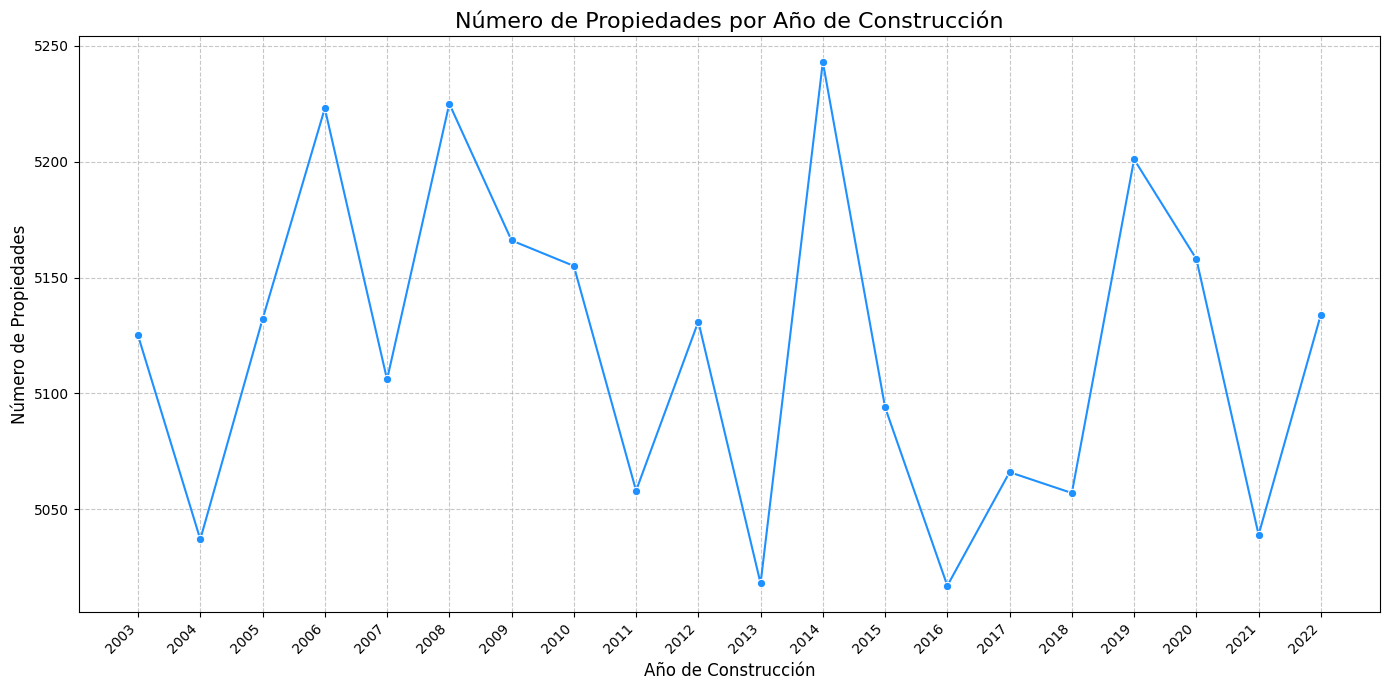

2025-05-17 00:10:44,882 - INFO - Gráfico de líneas para 'construction_year' generado y mostrado.


In [91]:
# Celda 15: Análisis de 'construction_year' con Gráfico de Líneas
logging.info("Celda 15: Analizando 'construction_year' con un gráfico de líneas.")

if not df_cleaned.empty:
    if 'construction_year' in df_cleaned.columns:
        construction_year_counts = df_cleaned['construction_year'].dropna().value_counts().sort_index()
        
        if not construction_year_counts.empty:
            plt.figure(figsize=(14, 7))
            sns.lineplot(x=construction_year_counts.index.astype(float), y=construction_year_counts.values, marker='o', color='dodgerblue') # astype(float) para el plot
            plt.title('Número de Propiedades por Año de Construcción', fontsize=16)
            plt.xlabel('Año de Construcción', fontsize=12)
            plt.ylabel('Número de Propiedades', fontsize=12)
            plt.grid(True, linestyle='--', alpha=0.7)
            
            min_year, max_year = construction_year_counts.index.min(), construction_year_counts.index.max()
            if isinstance(min_year, pd.Timestamp) or isinstance(max_year, pd.Timestamp): # Handle if it's somehow timestamp
                min_year = min_year.year if isinstance(min_year, pd.Timestamp) else int(min_year)
                max_year = max_year.year if isinstance(max_year, pd.Timestamp) else int(max_year)
            else: # Convert Int64Proxy to int for range
                min_year = int(min_year)
                max_year = int(max_year)

            if (max_year - min_year) > 20:
                step = max(1, (max_year - min_year) // 20) # Ajustar step dinámicamente
                ticks = list(range(min_year, max_year + step, step))
                if min_year not in ticks: ticks.insert(0, min_year)
                if max_year not in ticks and max_year > ticks[-1]: ticks.append(max_year)
                plt.xticks(sorted(list(set(ticks))), rotation=45, ha='right')
            else:
                plt.xticks(construction_year_counts.index.astype(int), rotation=45, ha='right')

            plt.tight_layout()
            plt.show()
            logging.info("Gráfico de líneas para 'construction_year' generado y mostrado.")
        else:
            logging.warning("No hay datos válidos en 'construction_year' para el gráfico después de quitar NaNs.")
    else:
        logging.warning("La columna 'construction_year' no se encontró en df_cleaned.")
else:
    logging.warning("El DataFrame df_cleaned está vacío. No se puede analizar 'construction_year'.")


2025-05-17 00:10:44,891 - INFO - Celda 16: Analizando 'minimum_nights' con un gráfico de barras.
2025-05-17 00:10:44,903 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_1221687/2761008193.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n_min_nights.index.astype(str), y=top_n_min_nights.values,
2025-05-17 00:10:44,909 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


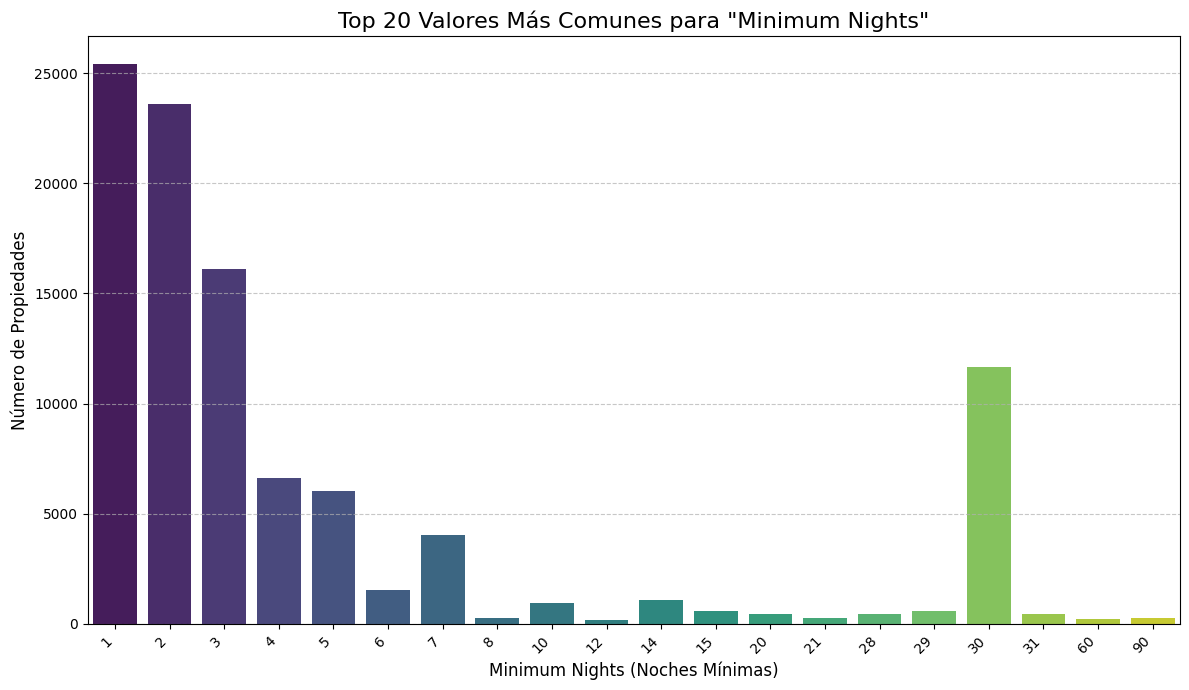

2025-05-17 00:10:45,103 - INFO - Gráfico de barras para los top 20 'minimum_nights' generado y mostrado.


Top 20 valores para 'minimum_nights':
|   minimum_nights |   count |
|-----------------:|--------:|
|                1 |   25421 |
|                2 |   23604 |
|                3 |   16113 |
|               30 |   11653 |
|                4 |    6625 |
|                5 |    6051 |
|                7 |    4039 |
|                6 |    1538 |
|               14 |    1077 |
|               10 |     932 |
|               15 |     593 |
|               29 |     569 |
|               31 |     453 |
|               20 |     440 |
|               28 |     432 |
|               21 |     256 |
|               90 |     248 |
|                8 |     246 |
|               60 |     234 |
|               12 |     171 |


In [92]:
# Celda 16: Análisis de 'minimum_nights' con Gráfico de Barras
logging.info("Celda 16: Analizando 'minimum_nights' con un gráfico de barras.")

if not df_cleaned.empty:
    if 'minimum_nights' in df_cleaned.columns:
        min_nights_counts = df_cleaned['minimum_nights'].dropna().value_counts()
        
        if not min_nights_counts.empty:
            N = 20 
            top_n_min_nights = min_nights_counts.nlargest(N)
            
            if not top_n_min_nights.empty:
                plt.figure(figsize=(12, 7))
                # Convertir índice a string para orden categórico, pero ordenar numéricamente antes del plot
                sorted_top_n_index = top_n_min_nights.index.astype('Int64').sort_values().astype(str)

                sns.barplot(x=top_n_min_nights.index.astype(str), y=top_n_min_nights.values, 
                            palette="viridis", order=sorted_top_n_index) # Usar el índice ordenado
                
                plt.title(f'Top {N} Valores Más Comunes para "Minimum Nights"', fontsize=16)
                plt.xlabel('Minimum Nights (Noches Mínimas)', fontsize=12)
                plt.ylabel('Número de Propiedades', fontsize=12)
                plt.xticks(rotation=45, ha='right')
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.show()
                logging.info(f"Gráfico de barras para los top {N} 'minimum_nights' generado y mostrado.")
                print(f"Top {N} valores para 'minimum_nights':")
                print(top_n_min_nights.to_markdown())
            else:
                logging.info(f"No hay suficientes datos para mostrar los top {N} valores de 'minimum_nights'.")
        else:
            logging.warning("No hay datos válidos en 'minimum_nights' para el gráfico después de quitar NaNs.")
    else:
        logging.warning("La columna 'minimum_nights' no se encontró en df_cleaned.")
else:
    logging.warning("El DataFrame df_cleaned está vacío. No se puede analizar 'minimum_nights'.")


2025-05-17 00:10:45,113 - INFO - Celda 17: Determinando el año con mayor actividad de reviews basado en 'last_review'.
2025-05-17 00:10:45,120 - INFO - El año con mayor actividad de 'últimos reviews' fue 2019 con 42931 reviews.
2025-05-17 00:10:45,132 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_1221687/132907764.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=year_counts.index.astype(int), y=year_counts.values, palette="inferno")
2025-05-17 00:10:45,139 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_

El año con mayor actividad de 'últimos reviews' fue: 2019
Número de 'últimos reviews' en ese año: 42931


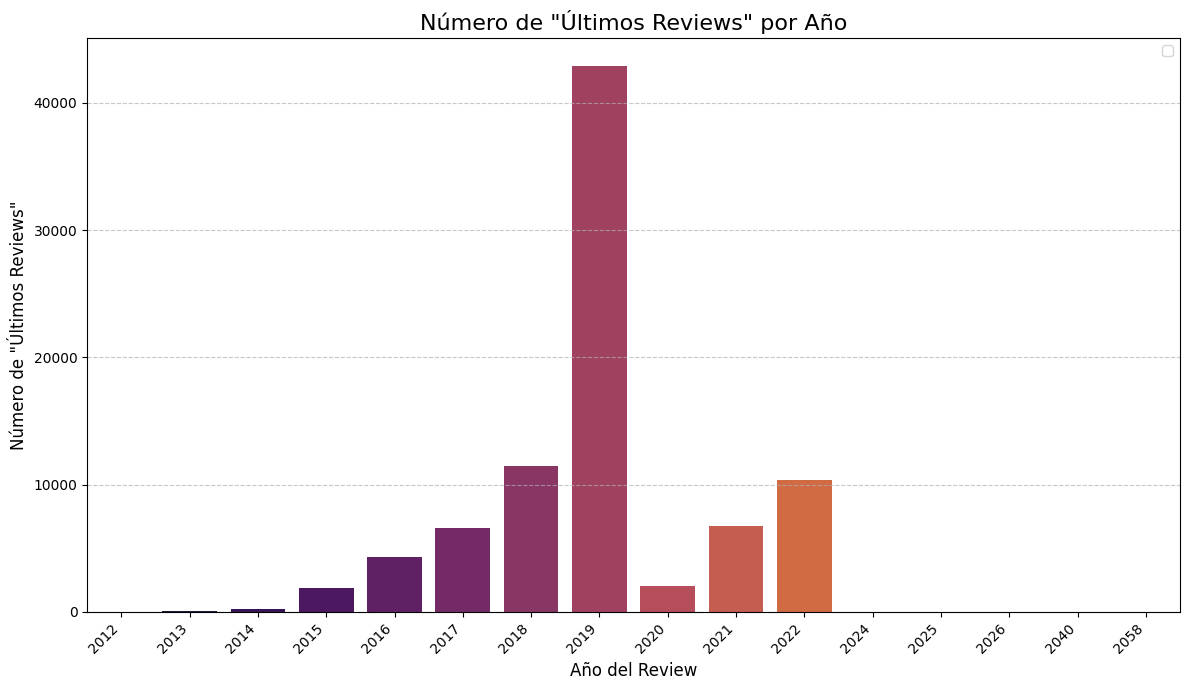

2025-05-17 00:10:45,329 - INFO - Gráfico de barras de actividad de reviews por año generado y mostrado.



Actividad de 'últimos reviews' por año:
|   last_review |   count |
|--------------:|--------:|
|          2012 |      26 |
|          2013 |      80 |
|          2014 |     246 |
|          2015 |    1874 |
|          2016 |    4316 |
|          2017 |    6601 |
|          2018 |   11455 |
|          2019 |   42931 |
|          2020 |    2063 |
|          2021 |    6740 |
|          2022 |   10369 |
|          2024 |       1 |
|          2025 |       1 |
|          2026 |       1 |
|          2040 |       1 |
|          2058 |       1 |


In [93]:
# Celda 17: Determinar el Año con Mayor Actividad de Reviews (basado en 'last_review')
logging.info("Celda 17: Determinando el año con mayor actividad de reviews basado en 'last_review'.")

if not df_cleaned.empty:
    if 'last_review' in df_cleaned.columns and pd.api.types.is_datetime64_any_dtype(df_cleaned['last_review']):
        valid_last_reviews = df_cleaned['last_review'].dropna()
        
        if not valid_last_reviews.empty:
            review_years = valid_last_reviews.dt.year.astype('Int64')
            year_counts = review_years.value_counts().sort_index()
            
            if not year_counts.empty:
                most_active_year = year_counts.idxmax()
                max_reviews_count = year_counts.max()
                
                print(f"El año con mayor actividad de 'últimos reviews' fue: {most_active_year}")
                print(f"Número de 'últimos reviews' en ese año: {max_reviews_count}")
                logging.info(f"El año con mayor actividad de 'últimos reviews' fue {most_active_year} con {max_reviews_count} reviews.")

                plt.figure(figsize=(12, 7))
                sns.barplot(x=year_counts.index.astype(int), y=year_counts.values, palette="inferno")
                plt.title('Número de "Últimos Reviews" por Año', fontsize=16)
                plt.xlabel('Año del Review', fontsize=12)
                plt.ylabel('Número de "Últimos Reviews"', fontsize=12)
                plt.xticks(rotation=45, ha='right')
                plt.grid(axis='y', linestyle='--', alpha=0.7)
                
                plt.legend()
                plt.tight_layout()
                plt.show()
                logging.info("Gráfico de barras de actividad de reviews por año generado y mostrado.")
                print("\nActividad de 'últimos reviews' por año:")
                print(year_counts.to_markdown())
            else:
                logging.warning("No hay datos de años de review después de procesar 'last_review'.")
        else:
            logging.warning("La columna 'last_review' está vacía o solo contiene NaT.")
    elif 'last_review' not in df_cleaned.columns:
        logging.warning("La columna 'last_review' no se encontró en df_cleaned.")
    else:
        logging.warning(f"La columna 'last_review' no es de tipo datetime ({df_cleaned['last_review'].dtype}). No se puede extraer el año.")
else:
    logging.warning("El DataFrame df_cleaned está vacío. No se puede analizar la actividad de reviews.")


2025-05-17 00:10:45,341 - INFO - Celda 18: Analizando 'number_of_reviews' y 'reviews_per_month'.
2025-05-17 00:10:45,344 - INFO - Analizando la columna: number_of_reviews



--- Estadísticas Descriptivas para 'number_of_reviews' ---
|       |   number_of_reviews |
|:------|--------------------:|
| count |         102416      |
| mean  |             27.4837 |
| std   |             49.509  |
| min   |              0      |
| 25%   |              1      |
| 50%   |              7      |
| 75%   |             30      |
| max   |           1024      |


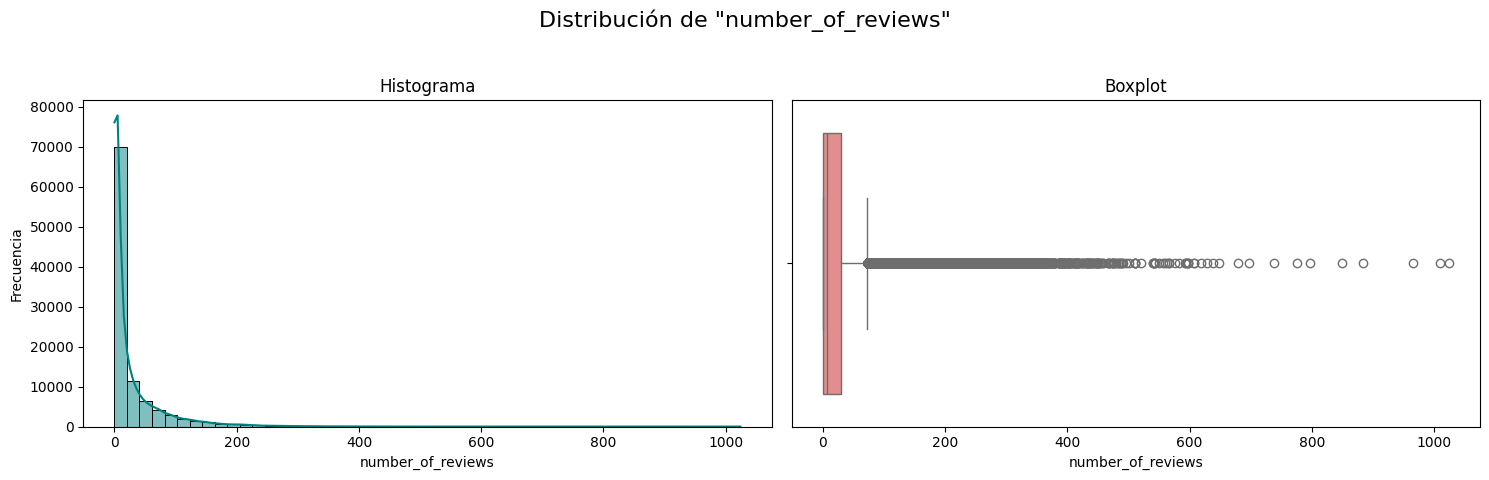

2025-05-17 00:10:46,011 - INFO - La columna 'number_of_reviews' está sesgada (skewness: 3.84). Mostrando con transformación logarítmica.


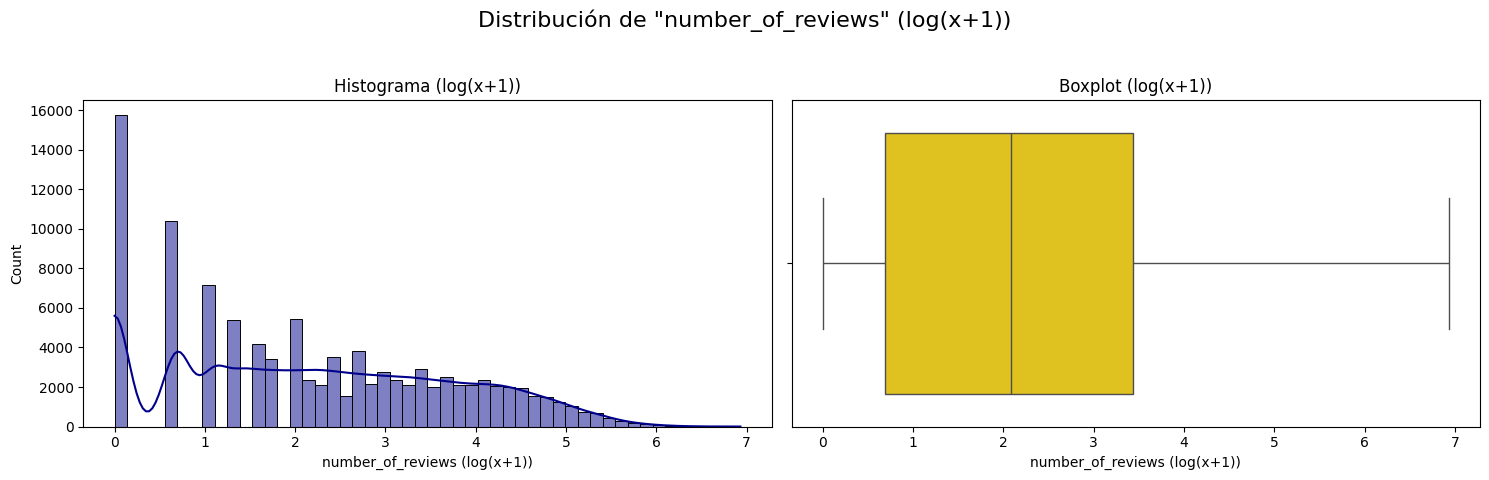

2025-05-17 00:10:46,555 - INFO - Analizando la columna: reviews_per_month



--- Estadísticas Descriptivas para 'reviews_per_month' ---
|       |   reviews_per_month |
|:------|--------------------:|
| count |         86720       |
| mean  |             1.37402 |
| std   |             1.74662 |
| min   |             0.01    |
| 25%   |             0.22    |
| 50%   |             0.74    |
| 75%   |             2       |
| max   |            90       |


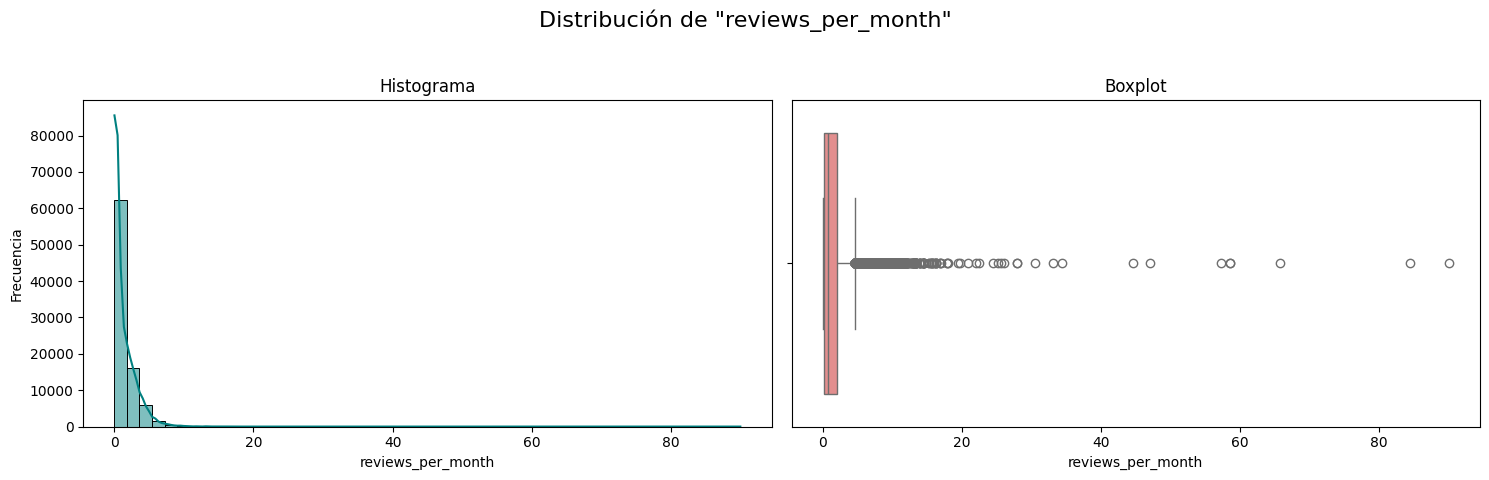

2025-05-17 00:10:47,021 - INFO - La columna 'reviews_per_month' está sesgada (skewness: 7.03). Mostrando con transformación logarítmica.


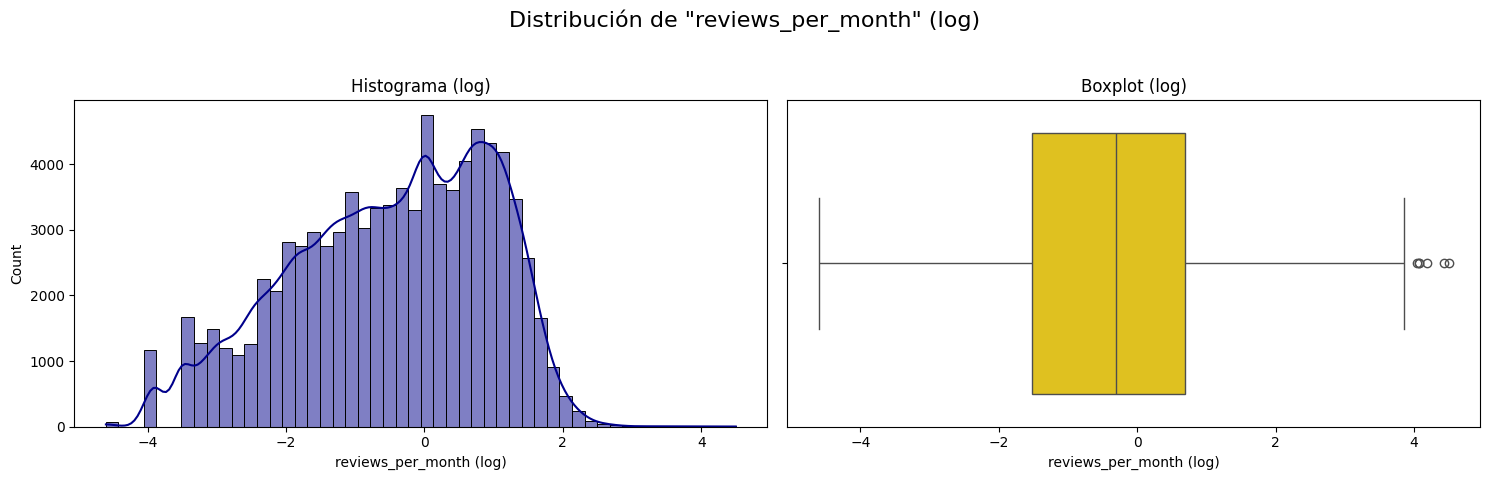

In [94]:
# Celda 18: Análisis de 'number_of_reviews' y 'reviews_per_month'
logging.info("Celda 18: Analizando 'number_of_reviews' y 'reviews_per_month'.")

if not df_cleaned.empty:
    cols_to_analyze = ['number_of_reviews', 'reviews_per_month']
    
    for col_name in cols_to_analyze:
        if col_name in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned[col_name]):
            data_series = df_cleaned[col_name].dropna()
            
            if not data_series.empty:
                logging.info(f"Analizando la columna: {col_name}")
                print(f"\n--- Estadísticas Descriptivas para '{col_name}' ---")
                print(data_series.describe().to_markdown())

                fig, axes = plt.subplots(1, 2, figsize=(15, 5))
                fig.suptitle(f'Distribución de "{col_name}"', fontsize=16)
                sns.histplot(data_series, bins=50, kde=True, ax=axes[0], color='teal')
                axes[0].set_title('Histograma')
                axes[0].set_xlabel(col_name); axes[0].set_ylabel('Frecuencia')
                sns.boxplot(x=data_series, ax=axes[1], color='lightcoral', orient='h')
                axes[1].set_title('Boxplot'); axes[1].set_xlabel(col_name)
                plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
                
                skewness = data_series.skew()
                if skewness > 2 or skewness < -2:
                    logging.info(f"La columna '{col_name}' está sesgada (skewness: {skewness:.2f}). Mostrando con transformación logarítmica.")
                    
                    data_for_log = data_series.copy()
                    log_label_suffix = ""
                    
                    if (data_for_log <= 0).any(): # Hay ceros o negativos
                        if (data_for_log == 0).all() or (data_for_log < 0).any():
                             logging.warning(f"No se puede aplicar log a '{col_name}' directamente debido a valores cero/negativos. Se omitirá el plot logarítmico.")
                             continue
                        elif (data_for_log == 0).any(): # Hay ceros, pero no negativos
                            data_for_log = data_for_log + 1 
                            log_label_suffix = " (log(x+1))"
                    else: # Todos positivos
                        log_label_suffix = " (log)"

                    if not (data_for_log <= 0).any(): # Doble chequeo después de la transformación x+1 si se hizo
                        log_data = np.log(data_for_log)
                        fig_log, axes_log = plt.subplots(1, 2, figsize=(15, 5))
                        fig_log.suptitle(f'Distribución de "{col_name}"{log_label_suffix}', fontsize=16)
                        sns.histplot(log_data, bins=50, kde=True, ax=axes_log[0], color='darkblue')
                        axes_log[0].set_title(f'Histograma{log_label_suffix}'); axes_log[0].set_xlabel(f'{col_name}{log_label_suffix}')
                        sns.boxplot(x=log_data, ax=axes_log[1], color='gold', orient='h')
                        axes_log[1].set_title(f'Boxplot{log_label_suffix}'); axes_log[1].set_xlabel(f'{col_name}{log_label_suffix}')
                        plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
                    else:
                         logging.warning(f"Después de ajustar para log, la serie para '{col_name}' aún contiene valores no positivos. Se omitirá el plot logarítmico.")
            else:
                logging.warning(f"La columna '{col_name}' está vacía o solo contiene NaNs.")
        elif col_name in df_cleaned.columns:
             logging.warning(f"La columna '{col_name}' no es numérica. Se omite.")
        else:
            logging.warning(f"La columna '{col_name}' no se encontró en df_cleaned.")
else:
    logging.warning("El DataFrame df_cleaned está vacío.")

2025-05-17 00:10:47,477 - INFO - Celda 19: Analizando 'review_rate_number'.
2025-05-17 00:10:47,481 - INFO - Generando gráfico de barras para 'review_rate_number'.
2025-05-17 00:10:47,494 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_1221687/278569687.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=review_rate_counts.index.astype(str), y=review_rate_counts.values, palette="coolwarm_r")
2025-05-17 00:10:47,500 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


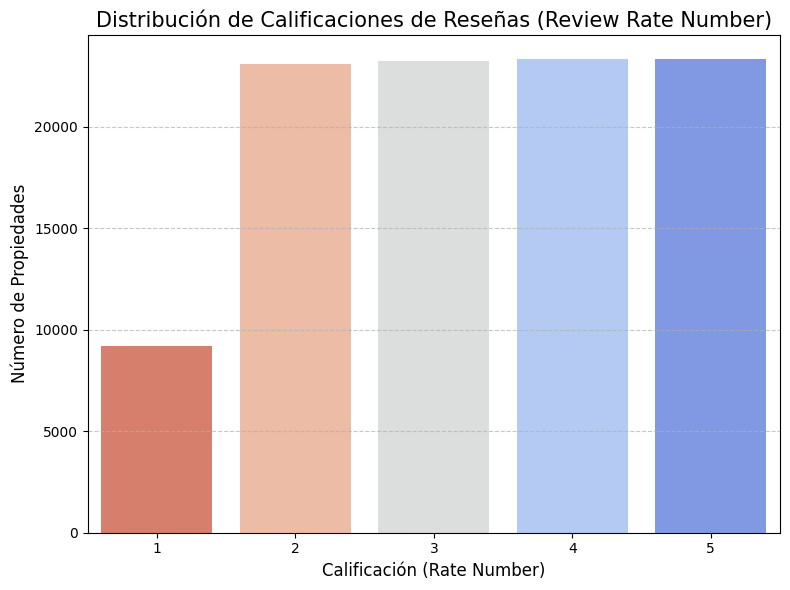


Frecuencia de cada 'review_rate_number':
|   review_rate_number |   count |
|---------------------:|--------:|
|                    1 |    9212 |
|                    2 |   23098 |
|                    3 |   23265 |
|                    4 |   23329 |
|                    5 |   23369 |


In [95]:
# Celda 19: Análisis de 'review_rate_number'
logging.info("Celda 19: Analizando 'review_rate_number'.")

if not df_cleaned.empty:
    if 'review_rate_number' in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned['review_rate_number']):
        review_rate_counts = df_cleaned['review_rate_number'].dropna().value_counts().sort_index()
        
        if not review_rate_counts.empty:
            logging.info("Generando gráfico de barras para 'review_rate_number'.")
            plt.figure(figsize=(8, 6))
            # Asegurar que el índice se trata como categórico para el plot, si es necesario.
            # Si ya es Int64, .astype(str) para barplot es una buena práctica si los números son etiquetas.
            sns.barplot(x=review_rate_counts.index.astype(str), y=review_rate_counts.values, palette="coolwarm_r")
            plt.title('Distribución de Calificaciones de Reseñas (Review Rate Number)', fontsize=15)
            plt.xlabel('Calificación (Rate Number)', fontsize=12)
            plt.ylabel('Número de Propiedades', fontsize=12)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout(); plt.show()
            print("\nFrecuencia de cada 'review_rate_number':")
            print(review_rate_counts.to_markdown())
        else:
            logging.warning("La columna 'review_rate_number' está vacía o solo contiene NaNs.")
    elif 'review_rate_number' in df_cleaned.columns:
        logging.warning(f"La columna 'review_rate_number' no es numérica. Se omite.")
    else:
        logging.warning("La columna 'review_rate_number' no se encontró en df_cleaned.")
else:
    logging.warning("El DataFrame df_cleaned está vacío.")


2025-05-17 00:10:47,613 - INFO - Celda 20: Generando matriz de histogramas y boxplots para columnas numéricas adicionales.


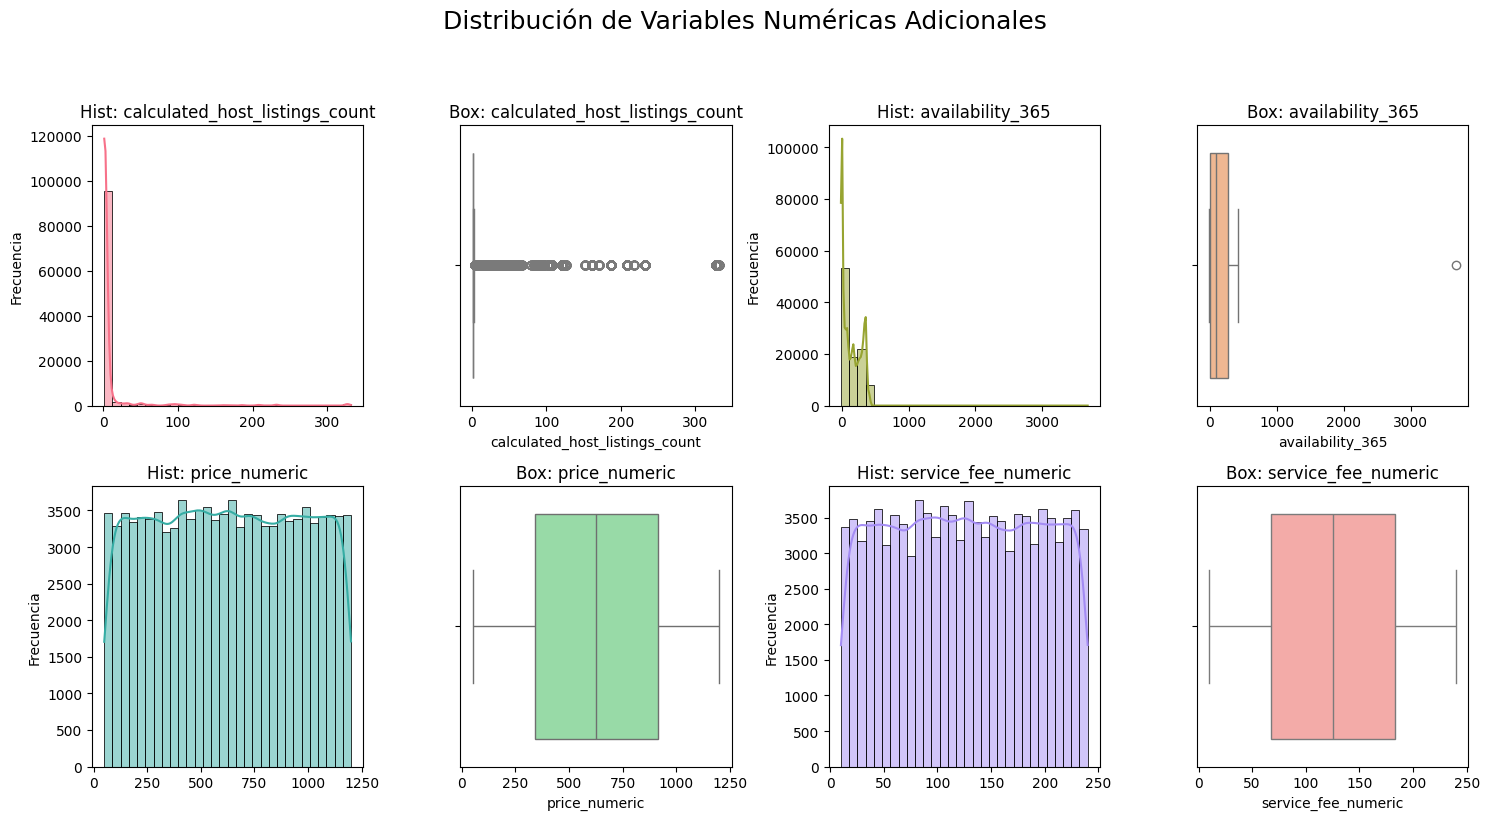

2025-05-17 00:10:49,497 - INFO - Matriz de histogramas y boxplots generada.
2025-05-17 00:10:49,498 - INFO - Fin del notebook de EDA (002_eda.ipynb).


In [96]:
# Celda 20: Matriz de Histogramas y Boxplots para Columnas Numéricas Adicionales
logging.info("Celda 20: Generando matriz de histogramas y boxplots para columnas numéricas adicionales.")

if not df_cleaned.empty:
    # Usar las columnas numéricas creadas en la limpieza: price_numeric, service_fee_numeric
    cols_for_matrix = [
        'calculated_host_listings_count', 
        'availability_365', 
        'price_numeric', 
        'service_fee_numeric'
    ]
    
    df_plot_temp = pd.DataFrame()
    valid_cols_for_plot = []

    for col_name in cols_for_matrix:
        if col_name in df_cleaned.columns and pd.api.types.is_numeric_dtype(df_cleaned[col_name]):
            df_plot_temp[col_name] = df_cleaned[col_name]
            valid_cols_for_plot.append(col_name)
        else:
            logging.warning(f"Columna '{col_name}' no encontrada o no numérica en df_cleaned. Se omitirá del plot matricial.")

    if not df_plot_temp.empty and valid_cols_for_plot:
        num_valid_cols = len(valid_cols_for_plot)
        n_cols_subplot_matrix = 2 # Dos "pares" de plots (hist+box) por fila
        n_rows_subplot_matrix = (num_valid_cols + n_cols_subplot_matrix - 1) // n_cols_subplot_matrix
        
        # Cada columna a plotear necesita 2 subplots (hist, box)
        # Entonces, la matriz de subplots será n_rows_subplot_matrix x (n_cols_subplot_matrix * 2)
        
        fig, axes_matrix = plt.subplots(n_rows_subplot_matrix, n_cols_subplot_matrix * 2, 
                                        figsize=(15, n_rows_subplot_matrix * 4), squeeze=False)
        # squeeze=False asegura que axes_matrix sea siempre 2D array
        
        fig.suptitle('Distribución de Variables Numéricas Adicionales', fontsize=18, y=1.02)
        
        plot_idx = 0 
        for r_matrix in range(n_rows_subplot_matrix):
            for c_matrix_group in range(n_cols_subplot_matrix):
                if plot_idx < num_valid_cols:
                    col_name_current = valid_cols_for_plot[plot_idx]
                    data_series_current = df_plot_temp[col_name_current].dropna()
                    
                    ax_hist_col_idx = c_matrix_group * 2
                    ax_box_col_idx = c_matrix_group * 2 + 1
                    
                    ax_h = axes_matrix[r_matrix, ax_hist_col_idx]
                    ax_b = axes_matrix[r_matrix, ax_box_col_idx]

                    if not data_series_current.empty:
                        sns.histplot(data_series_current, bins=30, kde=True, ax=ax_h, color=sns.color_palette("husl", num_valid_cols)[plot_idx])
                        ax_h.set_title(f'Hist: {col_name_current}'); ax_h.set_xlabel(''); ax_h.set_ylabel('Frecuencia')
                        sns.boxplot(x=data_series_current, ax=ax_b, orient='h', color=sns.color_palette("pastel", num_valid_cols)[plot_idx])
                        ax_b.set_title(f'Box: {col_name_current}'); ax_b.set_xlabel(col_name_current)
                    else:
                        ax_h.text(0.5, 0.5, f'No data for\n{col_name_current}', ha='center', va='center'); ax_h.set_title(f'Hist: {col_name_current}')
                        ax_b.text(0.5, 0.5, f'No data for\n{col_name_current}', ha='center', va='center'); ax_b.set_title(f'Box: {col_name_current}')
                    plot_idx += 1
                else: # Ocultar subplots no utilizados
                    if ax_hist_col_idx < axes_matrix.shape[1]: axes_matrix[r_matrix, ax_hist_col_idx].axis('off')
                    if ax_box_col_idx < axes_matrix.shape[1]: axes_matrix[r_matrix, ax_box_col_idx].axis('off')
        
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()
        logging.info("Matriz de histogramas y boxplots generada.")
    elif df_plot_temp.empty and valid_cols_for_plot: # Check if df_plot_temp is empty but valid_cols_for_plot is not (should not happen)
        print("Error: df_plot_temp is empty but valid_cols_for_plot is not. Check logic.")
        logging.error("Error: df_plot_temp is empty but valid_cols_for_plot is not.")
    elif not valid_cols_for_plot:
        print("No hay columnas válidas para generar la matriz de visualización después del filtrado.")
        logging.warning("valid_cols_for_plot está vacío. No se puede generar la matriz.")
else:
    logging.warning("El DataFrame df_cleaned está vacío.")
    print("El DataFrame df_cleaned está vacío.")

logging.info("Fin del notebook de EDA (002_eda.ipynb).")
